In [152]:
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import psycopg2
import get_data
from scipy.stats import linregress
from scipy.stats.mstats import winsorize
import scipy.stats as stats


In [153]:
df = pd.read_sql_query('SELECT datadate,gvkey,tic,cusip,gsector,cshoq,xrdq,xoprq FROM quarterly',get_data.engine)
df.rename(columns = {'tic':'ticker','datadate':'date'}, inplace=True)
#xrdq: Research and Development Expense
#xoprq: Operating Expense- Total 
#Common Shares Outstanding (cshoq)

df.head()
# Debt to equity ratio = dlttq / seqq

,date,gvkey,ticker,cusip,gsector,cshoq,xrdq,xoprq
0,2022-06-30,287462,FF,36116M106,10,43.763,0.755,116.605
1,2022-09-30,287462,FF,36116M106,10,43.763,0.967,98.677
2,2022-12-31,287462,FF,36116M106,10,43.763,1.014,103.434
3,2023-03-31,287462,FF,36116M106,10,43.763,1.072,53.379
4,2023-06-30,287462,FF,36116M106,10,43.763,1.007,94.287


In [154]:
df['rd_opex'] = (df['xrdq'])/df['xoprq']
df['rd_opex'] = df['rd_opex'].astype(float)

In [155]:
df_cleaned = df.dropna(axis = 0)

In [156]:
#getting rid of outliers
df_cleaned = df_cleaned[(df_cleaned['rd_opex'] > 0) & (df_cleaned['rd_opex'] < 1)]
print(min(df_cleaned['rd_opex']), max(df_cleaned['rd_opex']))

6.545202806885049e-05 0.9994227994227994


In [157]:
df_returns = pd.read_sql_query('SELECT date,cusip,ticker,ret,prc,askhi,bidlo FROM returns', get_data.engine)
df_returns['ret'] = pd.to_numeric(df_returns['ret'], errors='coerce')
df_returns['ret'] = df_returns['ret'].astype(float)
df_returns.head()

,date,cusip,ticker,ret,prc,askhi,bidlo
0,2019-06-28,89623910,TRMB,0.015762,45.11,45.24,44.49
1,2019-07-29,89623910,TRMB,-0.011376,44.32,44.96,44.25
2,2019-07-30,89623910,TRMB,0.002708,44.44,44.63,43.89
3,2019-07-31,89623910,TRMB,-0.049055,42.26,44.93,42.13
4,2019-08-28,89623910,TRMB,0.008018,36.46,36.73,35.86


In [158]:
#getting rid of outliers
df_returns = df_returns[(df_returns['ret'] > -0.25) & (df_returns['ret'] < 0.25)]
print(min(df_returns['ret']), max(df_returns['ret']))

-0.249704 0.249677


In [159]:
df_merged = pd.merge(df_cleaned, df_returns, on=['ticker', 'date'])
df_merged['market_cap'] = (df_merged['cshoq'])*df_merged['prc']
df_merged['market_cap'] = df_merged['market_cap'].astype(float)
df_merged.head()

,date,gvkey,ticker,cusip_x,gsector,cshoq,xrdq,xoprq,rd_opex,cusip_y,ret,prc,askhi,bidlo,market_cap
0,2022-06-30,287462,FF,36116M106,10,43.763,0.755,116.605,0.006475,36116M10,0.018182,7.28,7.28,7.0300,318.59464
1,2022-06-30,287462,FF,36116M106,10,43.763,0.755,116.605,0.006475,36116M10,0.018182,7.28,7.28,7.0300,318.59464
2,2022-09-30,287462,FF,36116M106,10,43.763,0.967,98.677,0.009800,36116M10,-0.001653,6.04,6.16,5.9950,264.32852
3,2022-09-30,287462,FF,36116M106,10,43.763,0.967,98.677,0.009800,36116M10,-0.001653,6.04,6.16,5.9950,264.32852
4,2023-03-31,287462,FF,36116M106,10,43.763,1.072,53.379,0.020083,36116M10,0.023578,7.38,7.39,7.2144,322.97094


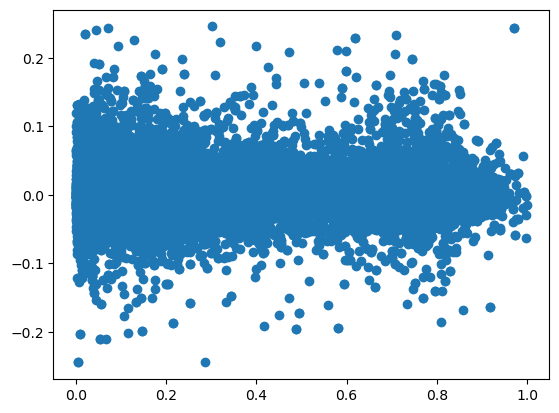

In [160]:
plt.scatter(df_merged.rd_opex, df_merged.ret)

In [161]:
#gsector indicates sector type. 35 is healthcare and 45 is tech
df_IT_HC = df_cleaned[df_cleaned['gsector'].isin(["35", "45"])].copy()

df_IT_HC.head()

,date,gvkey,ticker,cusip,gsector,cshoq,xrdq,xoprq,rd_opex
595,2001-06-30,002577,CTS,126501105,45,27.886,7.488,131.645,0.056880
596,2001-09-30,002577,CTS,126501105,45,28.876,8.118,117.418,0.069138
597,2001-12-31,002577,CTS,126501105,45,30.902,7.376,119.219,0.061869
598,2002-03-31,002577,CTS,126501105,45,33.117,7.133,100.355,0.071078
599,2002-06-30,002577,CTS,126501105,45,33.562,6.021,107.175,0.056179


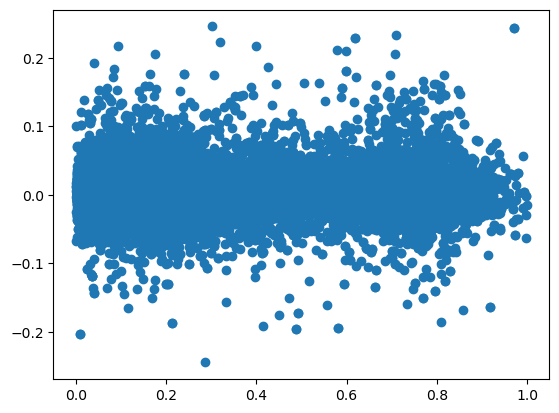

In [162]:
df_merged_IT_HC = pd.merge(df_IT_HC, df_returns, on=['ticker', 'date'])
plt.scatter(df_merged_IT_HC.rd_opex, df_merged_IT_HC.ret)

In [163]:
print(len(df_merged))
print(len(df_merged_IT_HC))

33784
21023


In [164]:
for ticker in df_merged_IT_HC['ticker'].unique():
    print(ticker)

CTS
COHU
FATE
CMTL
COO
GLW
DHR
DBD
DIOD
KODK
CYBE
CYTK
APPS
CLFD
CNMD
XRAY
FICO
CGNX
DELL
COHR
ESPR
ENTA
CRUS
DGII
COMM
EGRX
FIVN
CSCO
FCUV
CHRS
FGEN
GDDY
COLL
EVH
GKOS
GILD
GBT
DZSI
EDIT
EIGR
EVBG
FLGT
COUP
DOMO
ETWO
CVT
CFLT
HLIT
DNLI
DCPH
EOLS
DBX
DOCU
CRNX
ELAN
ESTC
GOSS
FSLY
CRWD
FULC
DT
NVST
NET
DDOG
GDYN
FMTX
GBIO
DCT
HRMY
DYN
COGT
CRSR
FHTX
DCGO
CGEM
GRNA
CORZ
EQRX
DOCN
DV
DSGN
EWTX
DAWN
EVCM
DOCS
YOU
BASE
ERAS
LAW
CTKB
EVLV
DH
DICE
ESMT
HLTH
ENFN
CCSI
GFS
CINC
CRDO
EMBC
CTXS
GERN
CIEN
CTIC
EXTR
FARO
EGAN
EXEL
FORM
FFIV
EXAS
EW
CCMP
ENTG
DVAX
CORT
CUTR
HALO
CYRX
DLB
DXCM
GMED
CVLT
FSLR
EBS
EGIO
ENOV
CDXS
DMRC
FTNT
ENV
CLSK
ENPH
EYPT
SWKS
QDEL
PAR
PFE
POLY
ROG
STAA
PRTA
RNG
SMTC
SYK
VTGN
QLYS
ORCL
RGEN
RETA
OSUR
PLAB
PACB
PGEN
PINC
PTC
VIR
RVNC
QTWO
PAHC
RLMD
SAGE
OCUL
NVRO
NEWR
REGN
OPRX
MCRB
PRGS
SPNE
RPD
QCOM
PRGO
ROP
SRRA
SPNS
OGN
PSTG
NVCR
RGNX
PEN
SENS
SCWX
NTNX
OTLK
KIDS
PTGX
SANM
SWTX
OFIX
RVMD
SAIL
SIGA
OKTA
SSTI
SGH
RMD
PETQ
QTRX
RCKT
ONDS
SMAR
REPL
PRVB
SIBN
ORGO
SWAV

In [170]:
#pure correlation
correlation = df_merged['rd_opex'].corr(df_merged['ret'])
print(f'Pearson correlation: {correlation}')

Pearson correlation: 0.040840170713918135


AAPL  Data:
             date   gvkey ticker    cusip_x gsector      cshoq    xrdq  \
26388  2000-03-31  001690   AAPL  037833100      45    162.680    92.0   
26389  2000-06-30  001690   AAPL  037833100      45    324.826    97.0   
26390  2001-12-31  001690   AAPL  037833100      45    352.459   113.0   
26391  2002-09-30  001690   AAPL  037833100      45    358.959   117.0   
26392  2002-12-31  001690   AAPL  037833100      45    360.257   121.0   
...           ...     ...    ...        ...     ...        ...     ...   
26449  2022-03-31  001690   AAPL  037833100      45  16207.568  6387.0   
26450  2022-06-30  001690   AAPL  037833100      45  16095.378  6797.0   
26451  2022-09-30  001690   AAPL  037833100      45  15943.425  6761.0   
26452  2023-03-31  001690   AAPL  037833100      45  15723.406  7457.0   
26453  2023-06-30  001690   AAPL  037833100      45  15647.868  7442.0   

         xoprq   rd_opex   cusip_y       ret       prc     askhi     bidlo  \
26388   1754.0  0.052

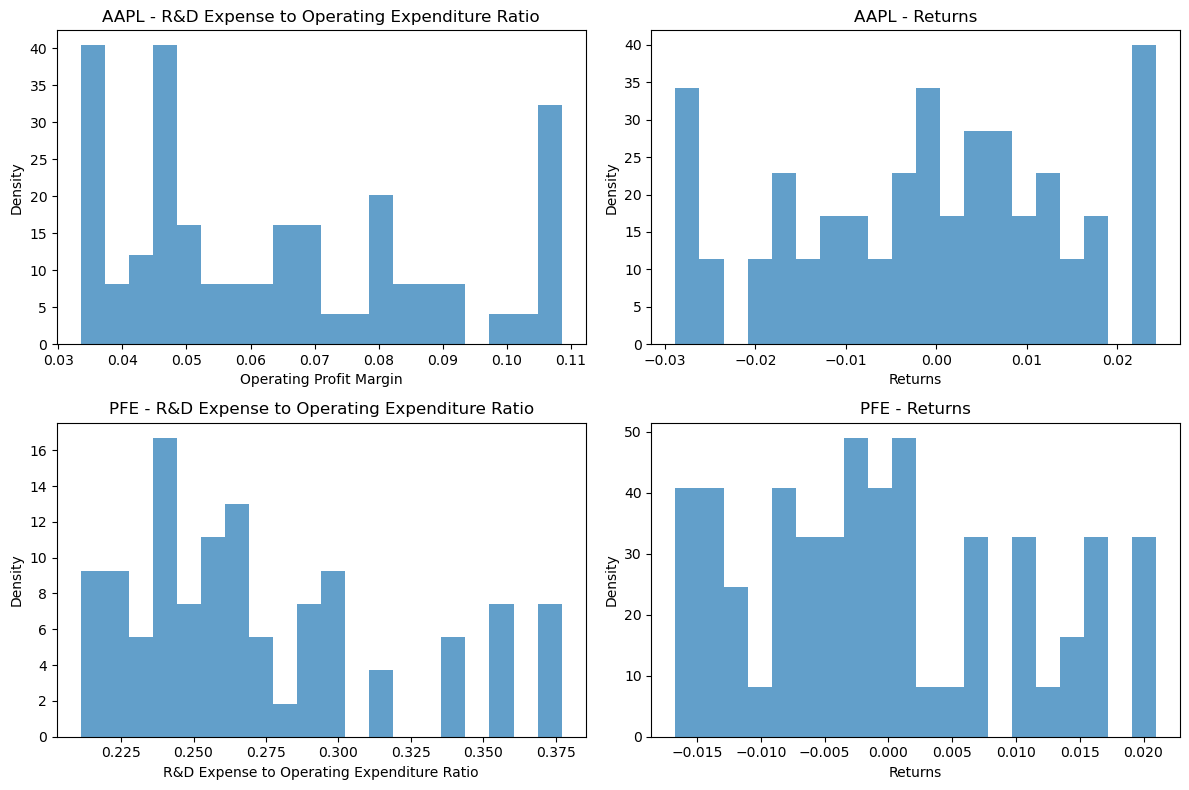

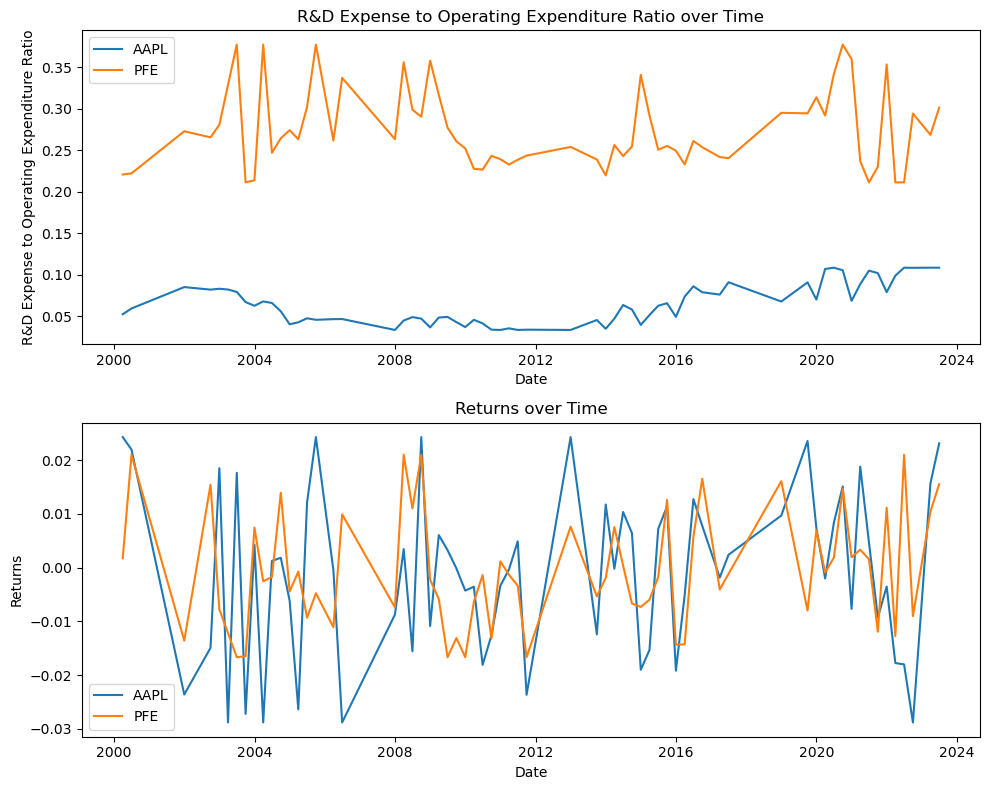

In [176]:
# graphing only two stocks
tech_ticker = 'AAPL'
healthcare_ticker = 'PFE'

tech_df = df_merged[df_merged['ticker'] == tech_ticker]
healthcare_df = df_merged[df_merged['ticker'] == healthcare_ticker]

tech_df = tech_df.sort_values('date')
healthcare_df = healthcare_df.sort_values('date')

required_columns = ['date', 'rd_opex', 'ret']
missing_columns_apple = [col for col in required_columns if col not in tech_df.columns]
missing_columns_pfe = [col for col in required_columns if col not in healthcare_df.columns]

# winsorization
winsorization_level = 0.05  # 5% winsorization level
tech_df['rd_opex'] = stats.mstats.winsorize(tech_df['rd_opex'], limits=[winsorization_level, winsorization_level])
tech_df['ret'] = stats.mstats.winsorize(tech_df['ret'], limits=[winsorization_level, winsorization_level])
healthcare_df['rd_opex'] = stats.mstats.winsorize(healthcare_df['rd_opex'], limits=[winsorization_level, winsorization_level])
healthcare_df['ret'] = stats.mstats.winsorize(healthcare_df['ret'], limits=[winsorization_level, winsorization_level])

# select the relevant columns for the new DataFrames
tech_result = tech_df[['date', 'gsector','xrdq', 'xoprq', 'rd_opex', 'ret']]
healthcare_result = healthcare_df[['date', 'gsector', 'xrdq', 'xoprq', 'rd_opex', 'ret']]

print(tech_ticker, " Data:")
print(tech_df)
print(healthcare_ticker, " Data:")
print(healthcare_df)

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0, 0].hist(tech_df['rd_opex'], bins=20, density=True, alpha=0.7)
axs[0, 0].set_title(f"{tech_ticker} - R&D Expense to Operating Expenditure Ratio")
axs[0, 0].set_xlabel('Operating Profit Margin')
axs[0, 0].set_ylabel('Density')

axs[0, 1].hist(tech_df['ret'], bins=20, density=True, alpha=0.7)
axs[0, 1].set_title(f"{tech_ticker} - Returns")
axs[0, 1].set_xlabel('Returns')
axs[0, 1].set_ylabel('Density')

axs[1, 0].hist(healthcare_df['rd_opex'], bins=20, density=True, alpha=0.7)
axs[1, 0].set_title(f"{healthcare_ticker} - R&D Expense to Operating Expenditure Ratio")
axs[1, 0].set_xlabel('R&D Expense to Operating Expenditure Ratio')
axs[1, 0].set_ylabel('Density')

axs[1, 1].hist(healthcare_df['ret'], bins=20, density=True, alpha=0.7)
axs[1, 1].set_title(f"{healthcare_ticker} - Returns")
axs[1, 1].set_xlabel('Returns')
axs[1, 1].set_ylabel('Density')

plt.tight_layout()
plt.show()

# subplots for operating profit margin and sales growth rate
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

ax1.plot(tech_df['date'], tech_df['rd_opex'], label=tech_ticker)
ax1.plot(healthcare_df['date'], healthcare_df['rd_opex'], label=healthcare_ticker)
ax1.set_xlabel('Date')
ax1.set_ylabel('R&D Expense to Operating Expenditure Ratio')
ax1.set_title('R&D Expense to Operating Expenditure Ratio over Time')
ax1.legend()

ax2.plot(tech_df['date'], tech_df['ret'], label=tech_ticker)
ax2.plot(healthcare_df['date'], healthcare_df['ret'], label=healthcare_ticker)
ax2.set_xlabel('Date')
ax2.set_ylabel('Returns')
ax2.set_title('Returns over Time')
ax2.legend()

plt.tight_layout()
plt.show()

In [167]:
# Select all tech and healthcare stocks based on 'gsector' column
tech_stocks = df_merged[df_merged['gsector'] == "45"]
healthcare_stocks = df_merged[df_merged['gsector'] == "35"]

# Sort the DataFrames by 'date'
tech_stocks = tech_stocks.sort_values('date')
healthcare_stocks = healthcare_stocks.sort_values('date')

required_columns = ['date', 'rd_opex', 'ret']
missing_columns_tech = [col for col in required_columns if col not in tech_stocks.columns]
missing_columns_healthcare = [col for col in required_columns if col not in healthcare_stocks.columns]

# Check for missing columns and apply winsorization if no missing columns are found
if missing_columns_tech:
    print(f"Error: Missing columns in Tech DataFrame: {missing_columns_tech}")
elif missing_columns_healthcare:
    print(f"Error: Missing columns in Healthcare DataFrame: {missing_columns_healthcare}")
else:
    # 5% winsorization level
    winsorization_level = 0.05
    for column in ['rd_opex', 'ret']:
        tech_stocks[column] = tech_stocks.groupby('date')[column].transform(lambda x: stats.mstats.winsorize(x, limits=[winsorization_level, winsorization_level]))
        healthcare_stocks[column] = healthcare_stocks.groupby('date')[column].transform(lambda x: stats.mstats.winsorize(x, limits=[winsorization_level, winsorization_level]))

    # select the relevant columns for the new DataFrames
    tech_result = tech_stocks[['date', 'gsector', 'xrdq', 'xoprq', 'rd_opex', 'ret']]
    healthcare_result = healthcare_stocks[['date', 'gsector', 'xrdq', 'xoprq', 'rd_opex', 'ret']]

    print("Tech Sector Data:")
    print(tech_result)
    print("\nHealthcare Sector Data:")
    print(healthcare_result)

Tech Sector Data:
             date gsector      xrdq     xoprq   rd_opex       ret
26125  2000-01-31      45     2.179    24.188  0.090086 -0.005208
26291  2000-01-31      45    82.516   336.751  0.245036 -0.020942
706    2000-01-31      45     0.581    12.274  0.047336  0.015152
707    2000-01-31      45     0.581    12.274  0.047336  0.015152
26454  2000-01-31      45   223.280  1193.141  0.187136  0.057803
...           ...     ...       ...       ...       ...       ...
15708  2023-11-30      45  2226.000  7670.000  0.290222  0.000000
8041   2023-11-30      45    24.937   117.534  0.212168  0.000000
16755  2023-11-30      45    34.005   123.771  0.274741 -0.002860
17605  2023-11-30      45    21.389   250.892  0.085252 -0.008333
27992  2023-11-30      45   889.000  3005.000  0.295840 -0.010334

[10747 rows x 6 columns]

Healthcare Sector Data:
             date gsector     xrdq     xoprq   rd_opex       ret
866    2000-01-31      35    0.648    30.153  0.021490 -0.024194
867    20

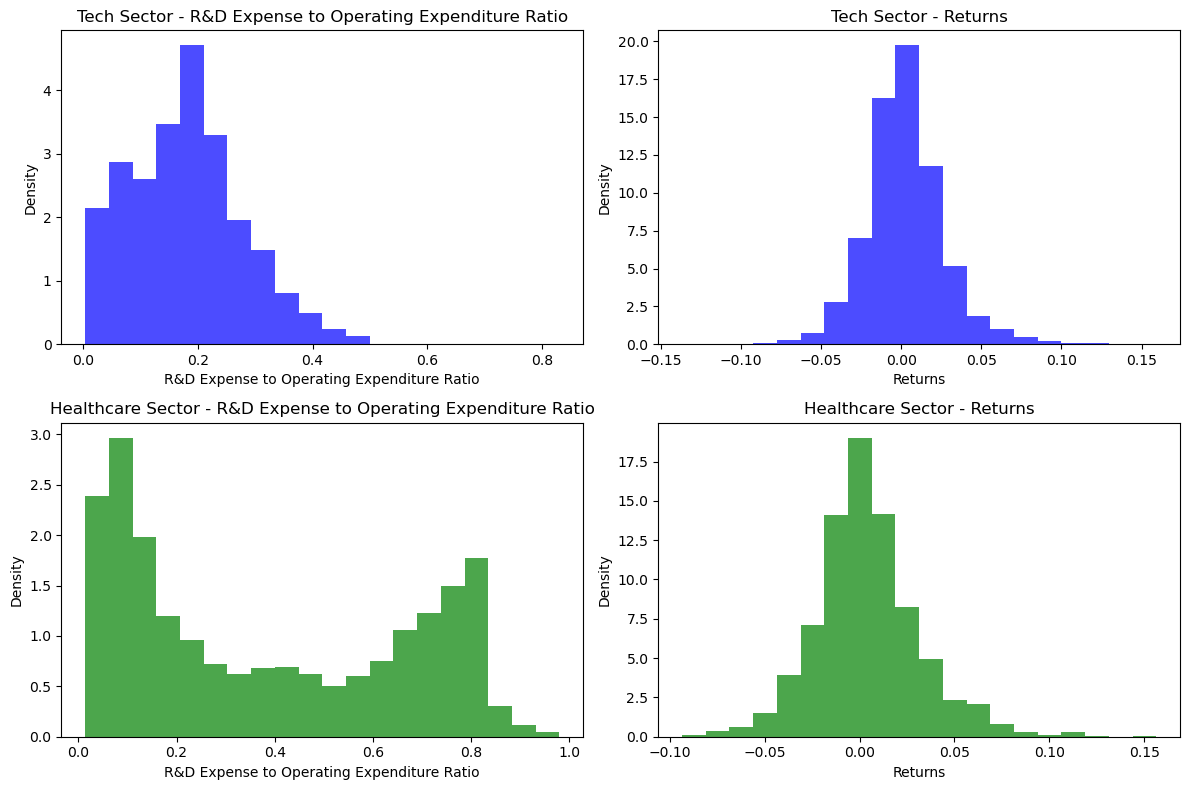

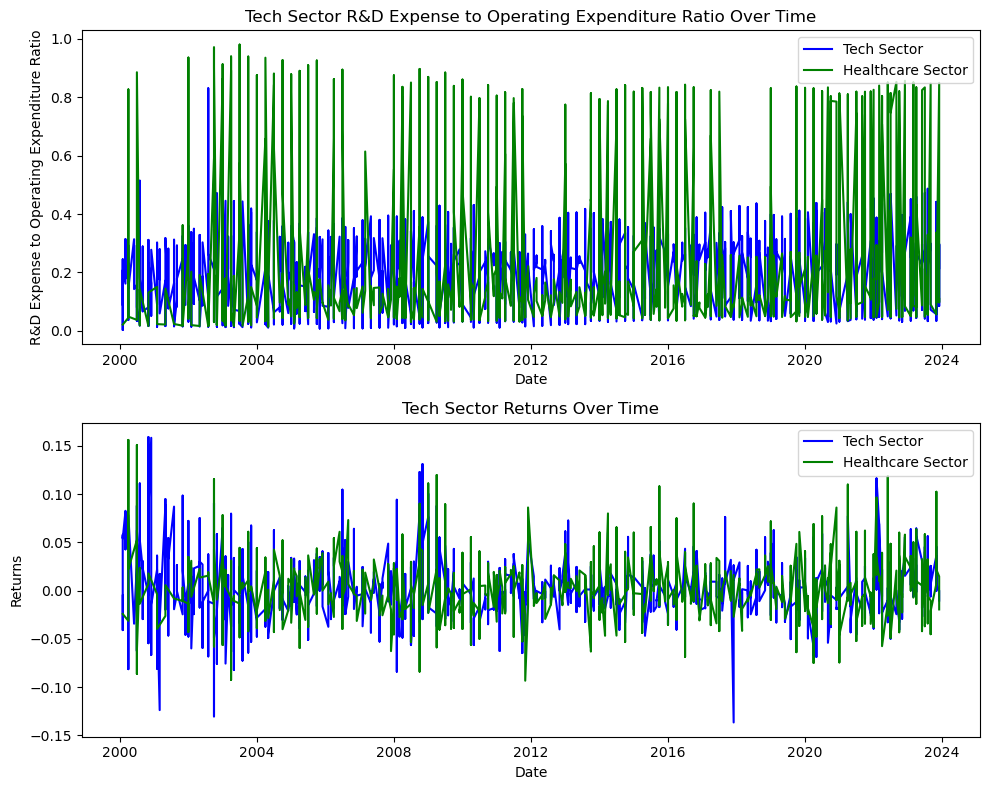

In [171]:
#graphing the entire industry 

# Plotting histograms for the Tech and Healthcare sectors
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Histogram for Tech Sector R&D Expense to Operating Expenditure Ratio
axs[0, 0].hist(tech_stocks['rd_opex'], bins=20, density=True, alpha=0.7, color='blue')
axs[0, 0].set_title("Tech Sector - R&D Expense to Operating Expenditure Ratio")
axs[0, 0].set_xlabel('R&D Expense to Operating Expenditure Ratio')
axs[0, 0].set_ylabel('Density')

# Histogram for Tech Sector Returns
axs[0, 1].hist(tech_stocks['ret'], bins=20, density=True, alpha=0.7, color='blue')
axs[0, 1].set_title("Tech Sector - Returns")
axs[0, 1].set_xlabel('Returns')
axs[0, 1].set_ylabel('Density')

# Histogram for Healthcare Sector R&D Expense to Operating Expenditure Ratio
axs[1, 0].hist(healthcare_stocks['rd_opex'], bins=20, density=True, alpha=0.7, color='green')
axs[1, 0].set_title("Healthcare Sector - R&D Expense to Operating Expenditure Ratio")
axs[1, 0].set_xlabel('R&D Expense to Operating Expenditure Ratio')
axs[1, 0].set_ylabel('Density')

# Histogram for Healthcare Sector Returns
axs[1, 1].hist(healthcare_stocks['ret'], bins=20, density=True, alpha=0.7, color='green')
axs[1, 1].set_title("Healthcare Sector - Returns")
axs[1, 1].set_xlabel('Returns')
axs[1, 1].set_ylabel('Density')

plt.tight_layout()
plt.show()

# Now, let's plot the time series for both sectors.
# Subplots for R&D Expense to Operating Expenditure Ratio and Returns for both sectors
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Time series for Tech Sector R&D Expense to Operating Expenditure Ratio
ax1.plot(tech_stocks['date'], tech_stocks['rd_opex'], label='Tech Sector', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('R&D Expense to Operating Expenditure Ratio')
ax1.set_title('Tech Sector R&D Expense to Operating Expenditure Ratio Over Time')
ax1.legend()

# Time series for Healthcare Sector R&D Expense to Operating Expenditure Ratio
ax1.plot(healthcare_stocks['date'], healthcare_stocks['rd_opex'], label='Healthcare Sector', color='green')
ax1.legend()

# Time series for Tech Sector Returns
ax2.plot(tech_stocks['date'], tech_stocks['ret'], label='Tech Sector', color='blue')
ax2.set_xlabel('Date')
ax2.set_ylabel('Returns')
ax2.set_title('Tech Sector Returns Over Time')
ax2.legend()

# Time series for Healthcare Sector Returns
ax2.plot(healthcare_stocks['date'], healthcare_stocks['ret'], label='Healthcare Sector', color='green')
ax2.legend()

plt.tight_layout()
plt.show()


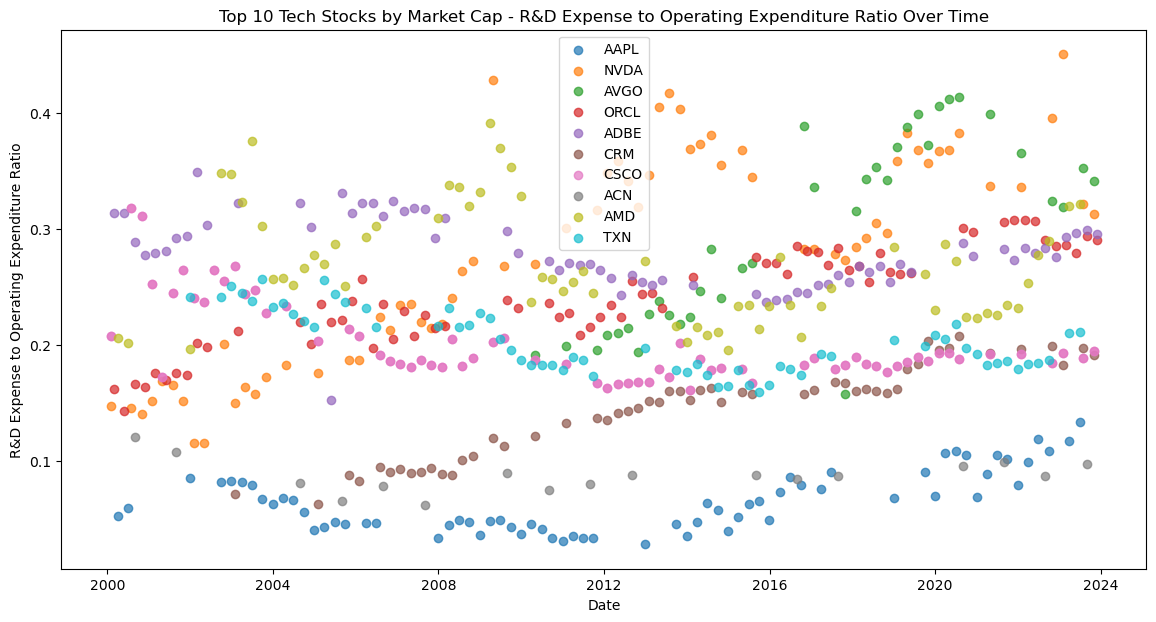

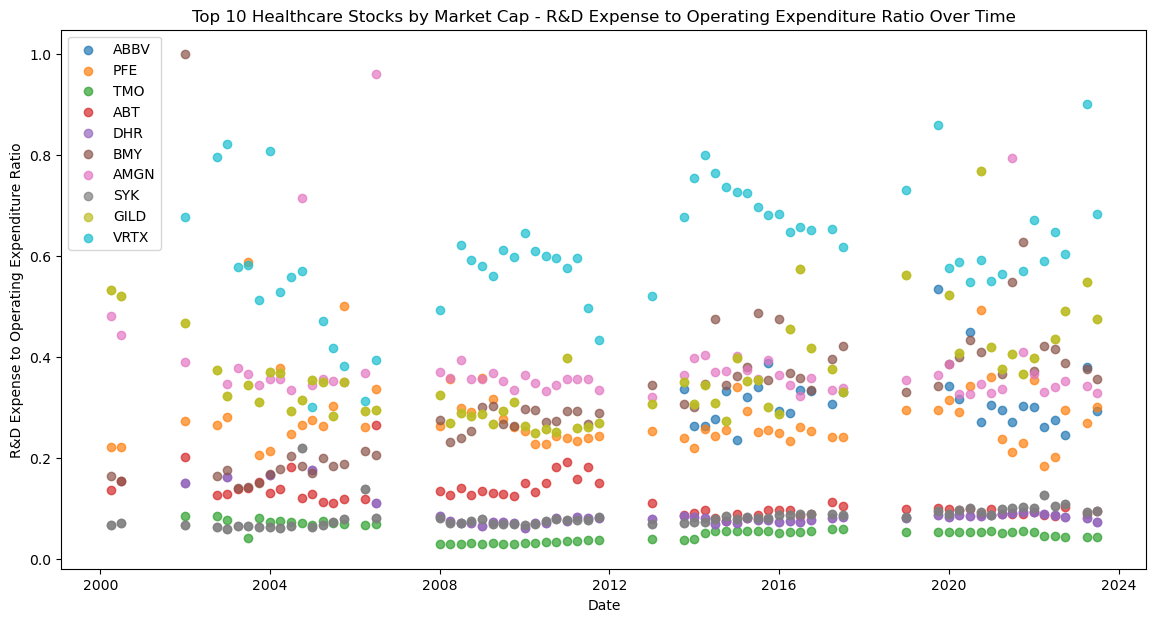

In [172]:

# Identify the top 10 tech stocks by market cap
top_tech_stocks = df_merged[df_merged['gsector'] == "45"].groupby('ticker').last().nlargest(10, 'market_cap')
top_healthcare_stocks = df_merged[df_merged['gsector'] == "35"].groupby('ticker').last().nlargest(10, 'market_cap')

# Extract the tickers for the top 10 market cap stocks in each sector
top_tech_tickers = top_tech_stocks.index
top_healthcare_tickers = top_healthcare_stocks.index

# Filter the original DataFrame to only include the top 10 tickers for each sector
filtered_tech_stocks = df_merged[df_merged['ticker'].isin(top_tech_tickers)]
filtered_healthcare_stocks = df_merged[df_merged['ticker'].isin(top_healthcare_tickers)]

# Scatter plot for the top 10 tech stocks by market cap
plt.figure(figsize=(14, 7))
for ticker in top_tech_tickers:
    subset = filtered_tech_stocks[filtered_tech_stocks['ticker'] == ticker]
    plt.scatter(subset['date'], subset['rd_opex'], label=ticker, alpha=0.7)

plt.xlabel('Date')
plt.ylabel('R&D Expense to Operating Expenditure Ratio')
plt.title('Top 10 Tech Stocks by Market Cap - R&D Expense to Operating Expenditure Ratio Over Time')
plt.legend()
plt.show()

# Scatter plot for the top 10 healthcare stocks by market cap
plt.figure(figsize=(14, 7))
for ticker in top_healthcare_tickers:
    subset = filtered_healthcare_stocks[filtered_healthcare_stocks['ticker'] == ticker]
    plt.scatter(subset['date'], subset['rd_opex'], label=ticker, alpha=0.7)

plt.xlabel('Date')
plt.ylabel('R&D Expense to Operating Expenditure Ratio')
plt.title('Top 10 Healthcare Stocks by Market Cap - R&D Expense to Operating Expenditure Ratio Over Time')
plt.legend()
plt.show()

# Note: Depending on how 'market_cap' is structured (e.g., if it's time-series data for each stock), you might need to adjust the grouping strategy to correctly identify the top 10 stocks.


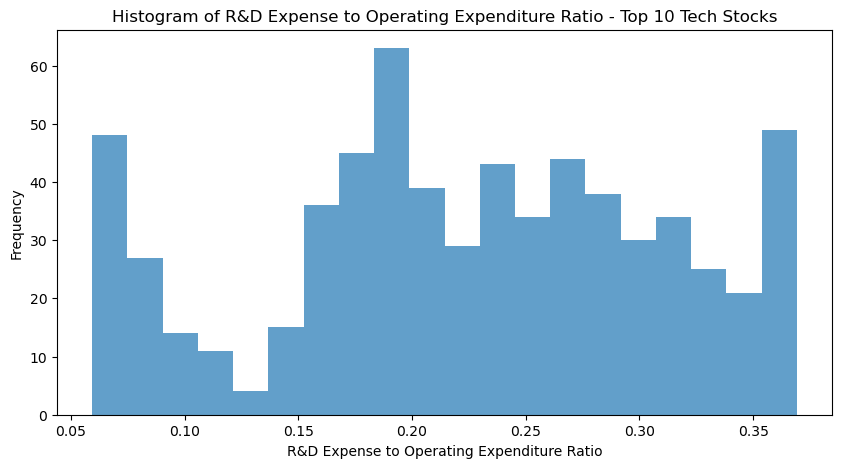

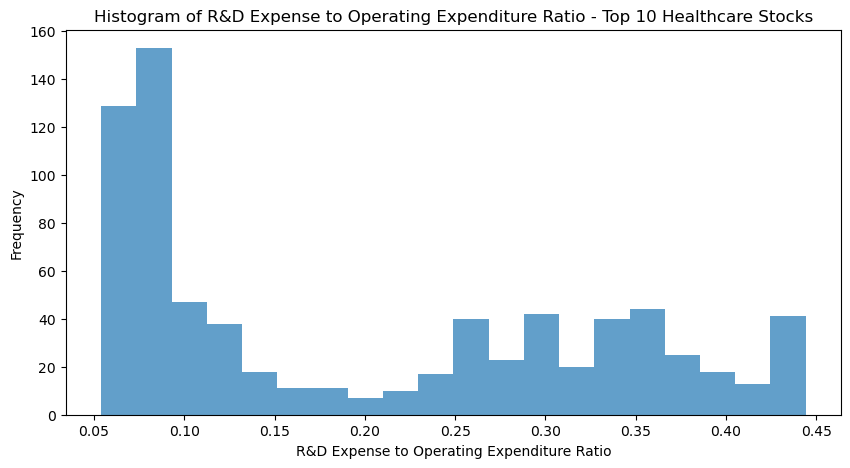

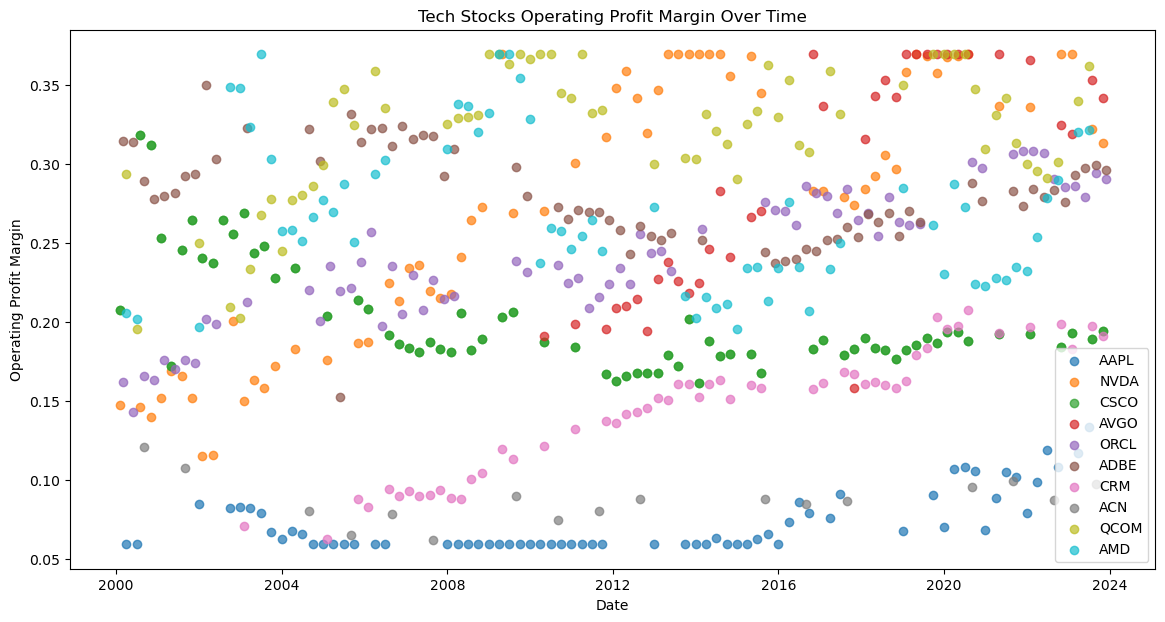

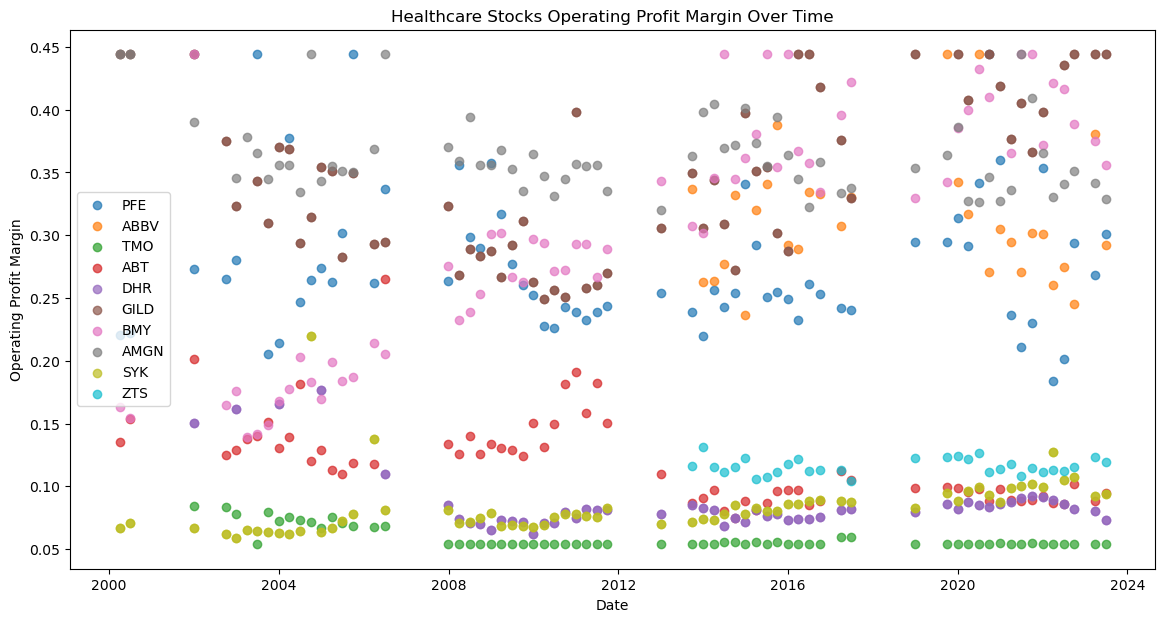

In [173]:
import matplotlib.pyplot as plt
from scipy import stats

# Select all tech and healthcare stocks based on 'gsector' column
tech_stocks_all = df_merged[df_merged['gsector'] == "45"]
healthcare_stocks_all = df_merged[df_merged['gsector'] == "35"]

# Determine the top 10 tech and healthcare stocks by market cap
top_tech_stocks = tech_stocks_all.groupby('ticker').max().nlargest(10, 'market_cap').index
top_healthcare_stocks = healthcare_stocks_all.groupby('ticker').max().nlargest(10, 'market_cap').index

# Filter the original data to include only the top 10 market cap stocks
tech_stocks = tech_stocks_all[tech_stocks_all['ticker'].isin(top_tech_stocks)]
healthcare_stocks = healthcare_stocks_all[healthcare_stocks_all['ticker'].isin(top_healthcare_stocks)]

# Sort the DataFrames by 'date'
tech_stocks = tech_stocks.sort_values('date')
healthcare_stocks = healthcare_stocks.sort_values('date')

# Checking for missing columns
required_columns = ['date', 'rd_opex', 'ret']
missing_columns_tech = [col for col in required_columns if col not in tech_stocks.columns]
missing_columns_healthcare = [col for col in required_columns if col not in healthcare_stocks.columns]

if missing_columns_tech:
    print(f"Error: Missing columns in Tech DataFrame: {missing_columns_tech}")
elif missing_columns_healthcare:
    print(f"Error: Missing columns in Healthcare DataFrame: {missing_columns_healthcare}")
else:
    # Winsorize the data
    winsorization_level = 0.05
    for column in ['rd_opex', 'ret']:
        tech_stocks[column] = stats.mstats.winsorize(tech_stocks[column], limits=[winsorization_level, winsorization_level])
        healthcare_stocks[column] = stats.mstats.winsorize(healthcare_stocks[column], limits=[winsorization_level, winsorization_level])

    # Select the relevant columns for the new DataFrames
    tech_result = tech_stocks[['date', 'ticker', 'gsector', 'xrdq', 'xoprq', 'rd_opex', 'ret']]
    healthcare_result = healthcare_stocks[['date', 'ticker', 'gsector', 'xrdq', 'xoprq', 'rd_opex', 'ret']]

    # Plot histograms and scatter plots as required
    # Histograms for R&D Expense to Operating Expenditure Ratio
    plt.figure(figsize=(10, 5))
    plt.hist(tech_result['rd_opex'], bins=20, alpha=0.7)
    plt.title('Histogram of R&D Expense to Operating Expenditure Ratio - Top 10 Tech Stocks')
    plt.xlabel('R&D Expense to Operating Expenditure Ratio')
    plt.ylabel('Frequency')
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.hist(healthcare_result['rd_opex'], bins=20, alpha=0.7)
    plt.title('Histogram of R&D Expense to Operating Expenditure Ratio - Top 10 Healthcare Stocks')
    plt.xlabel('R&D Expense to Operating Expenditure Ratio')
    plt.ylabel('Frequency')
    plt.show()

    # Scatterplots for Operating Profit Margin over time
    plt.figure(figsize=(14, 7))
    for ticker in top_tech_stocks:
        subset = tech_result[tech_result['ticker'] == ticker]
        plt.scatter(subset['date'], subset['rd_opex'], label=ticker, alpha=0.7)
    plt.title('Tech Stocks Operating Profit Margin Over Time')
    plt.xlabel('Date')
    plt.ylabel('Operating Profit Margin')
    plt.legend()
    plt.show()

    plt.figure(figsize=(14, 7))
    for ticker in top_healthcare_stocks:
        subset = healthcare_result[healthcare_result['ticker'] == ticker]
        plt.scatter(subset['date'], subset['rd_opex'], label=ticker, alpha=0.7)
    plt.title('Healthcare Stocks Operating Profit Margin Over Time')
    plt.xlabel('Date')
    plt.ylabel('Operating Profit Margin')
    plt.legend()
    plt.show()


/var/folders/tq/hd23s7wx6sbd0wl1x0gfc21c0000gn/T/ipykernel_32043/3940571904.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tech_result['returns_over_rd_ratio'] = tech_result['ret'] / tech_result['rd_opex']
/var/folders/tq/hd23s7wx6sbd0wl1x0gfc21c0000gn/T/ipykernel_32043/3940571904.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  healthcare_result['returns_over_rd_ratio'] = healthcare_result['ret'] / healthcare_result['rd_opex']


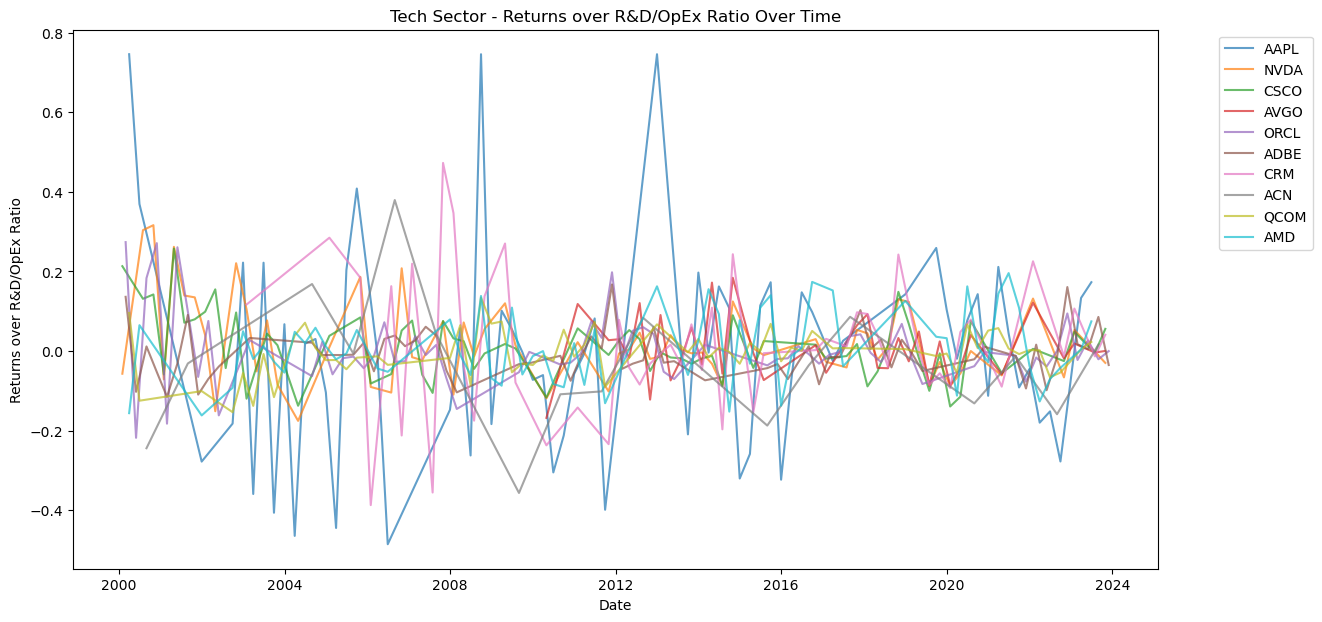

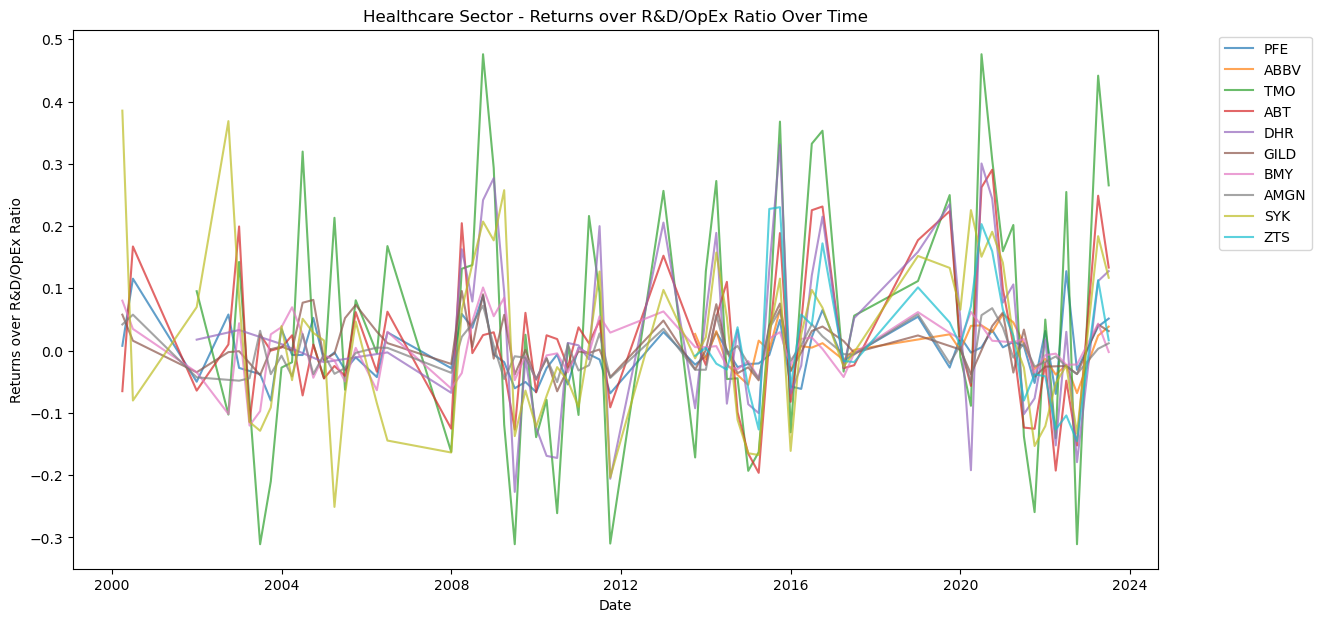

In [175]:
import matplotlib.pyplot as plt

# ... (previous data preparation code to get the top 10 tech and healthcare stocks) ...

# Calculate the ratio of Returns over R&D to Operating Expense Ratio
tech_result['returns_over_rd_ratio'] = tech_result['ret'] / tech_result['rd_opex']
healthcare_result['returns_over_rd_ratio'] = healthcare_result['ret'] / healthcare_result['rd_opex']

# Plotting the ratio against the date for tech stocks
plt.figure(figsize=(14, 7))
for ticker in top_tech_stocks:
    subset = tech_result[tech_result['ticker'] == ticker]
    plt.plot(subset['date'], subset['returns_over_rd_ratio'], label=ticker, alpha=0.7)

plt.xlabel('Date')
plt.ylabel('Returns over R&D/OpEx Ratio')
plt.title('Tech Sector - Returns over R&D/OpEx Ratio Over Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Plotting the ratio against the date for healthcare stocks
plt.figure(figsize=(14, 7))
for ticker in top_healthcare_stocks:
    subset = healthcare_result[healthcare_result['ticker'] == ticker]
    plt.plot(subset['date'], subset['returns_over_rd_ratio'], label=ticker, alpha=0.7)

plt.xlabel('Date')
plt.ylabel('Returns over R&D/OpEx Ratio')
plt.title('Healthcare Sector - Returns over R&D/OpEx Ratio Over Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
